2025-12-01 12:26:14.047329: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Feature matrix shape (rows, skill_dims): (941, 33)


/var/folders/0t/nvsb9hb16cz3yyv_k6byz7yr0000gn/T/ipykernel_47319/3665248831.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(unique_levels_sorted))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


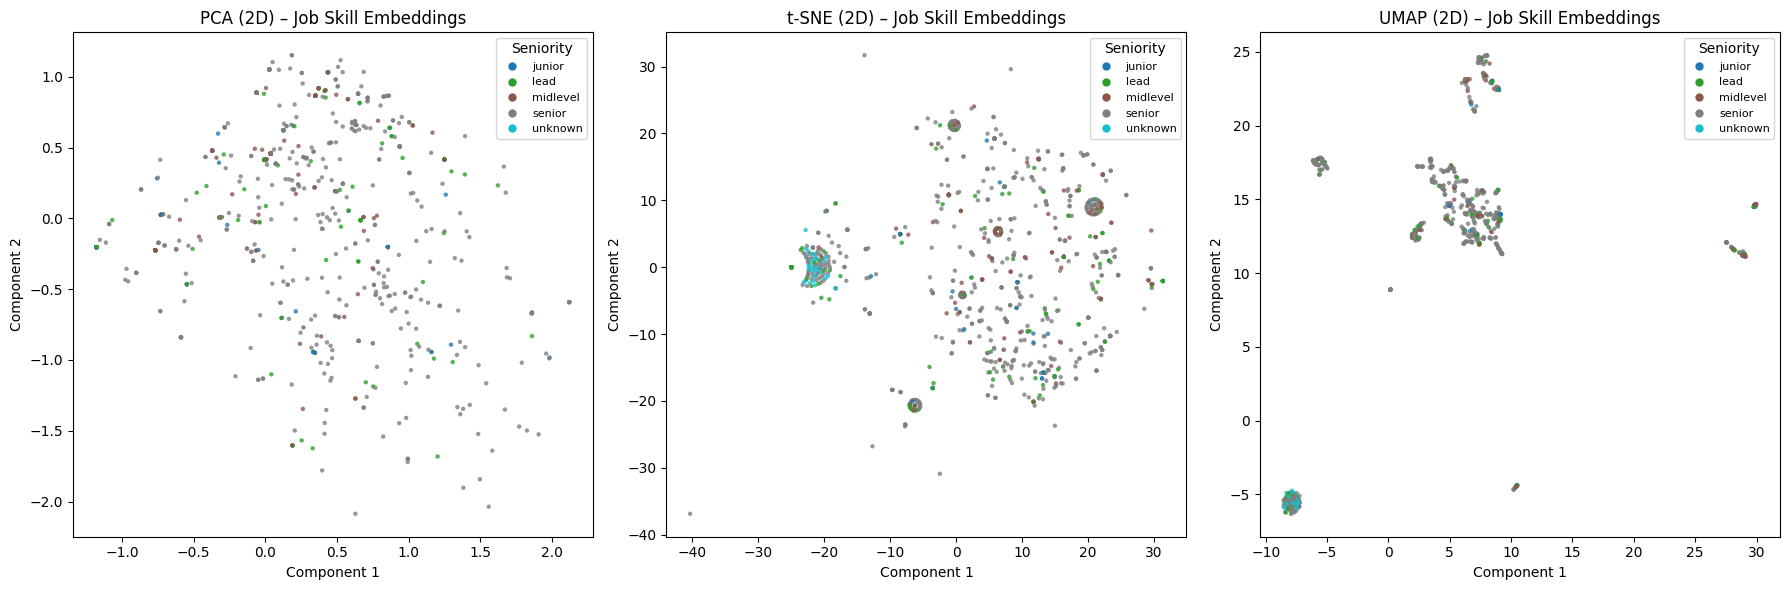

In [1]:
"""
Compute and plot PCA, t-SNE, and UMAP embeddings for job postings.

- Input: CSV with columns including:
    - skills_list  (e.g. "['spark', 'r', 'python', 'scala', 'machine learning']")
    - seniority_level (e.g. "junior", "mid", "senior")
- Output: Single figure with 3 scatter plots:
    - PCA 2D
    - t-SNE 2D
    - UMAP 2D
"""

import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# UMAP is a separate package:
# pip install umap-learn
import umap

# -------------------------------------------------------------------
# 1. Load data
# -------------------------------------------------------------------

CSV_PATH = "../data/data_science_job_posts_2025_clean.csv"  # <-- change if needed

df = pd.read_csv(CSV_PATH)

# Make sure these columns exist in your CSV
# Example row you showed:
# job_title, seniority_level, ..., skills_list, skills_clean
required_cols = ["skills_list", "seniority_level"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

# -------------------------------------------------------------------
# 2. Build feature matrix from skills
# -------------------------------------------------------------------
# skills_list is a string like: "['spark', 'r', 'python', ...]"
# We'll parse it into a Python list and then one-hot encode with MultiLabelBinarizer.

def parse_skills_list(s):
    if pd.isna(s):
        return []
    # Some rows may already be lists; handle both cases
    if isinstance(s, list):
        return s
    return ast.literal_eval(s)

df["skills_parsed"] = df["skills_list"].apply(parse_skills_list)

mlb = MultiLabelBinarizer()
X_skills = mlb.fit_transform(df["skills_parsed"])

print("Feature matrix shape (rows, skill_dims):", X_skills.shape)

# -------------------------------------------------------------------
# 3. Prepare colors (by seniority level)
# -------------------------------------------------------------------

df["seniority_level"] = df["seniority_level"].fillna("unknown")

unique_levels = df["seniority_level"].unique()
unique_levels_sorted = sorted(unique_levels)

level_to_idx = {level: i for i, level in enumerate(unique_levels_sorted)}
color_indices = df["seniority_level"].map(level_to_idx).values

cmap = plt.cm.get_cmap("tab10", len(unique_levels_sorted))

# -------------------------------------------------------------------
# 4. Compute embeddings
# -------------------------------------------------------------------

# 4.1 PCA (2D)
pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(X_skills)

# 4.2 t-SNE (2D)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)
tsne_2d = tsne.fit_transform(X_skills)

# 4.3 UMAP (2D)
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)
umap_2d = umap_reducer.fit_transform(X_skills)

# -------------------------------------------------------------------
# 5. Helper function to plot an embedding
# -------------------------------------------------------------------

def plot_embedding(ax, embedding, title, color_indices, cmap, legend_labels):
    x = embedding[:, 0]
    y = embedding[:, 1]

    scatter = ax.scatter(
        x,
        y,
        c=color_indices,
        cmap=cmap,
        s=10,
        alpha=0.8,
        edgecolors="none",
    )
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    # Build a legend for seniority levels
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(
            plt.Line2D(
                [], [], marker="o", linestyle="", markersize=6,
                markerfacecolor=cmap(i), markeredgecolor="none", label=label
            )
        )
    ax.legend(
        handles=handles,
        title="Seniority",
        loc="best",
        fontsize=8,
    )

# -------------------------------------------------------------------
# 6. Plot all three embeddings side by side
# -------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_embedding(
    axes[0],
    pca_2d,
    "PCA (2D) – Job Skill Embeddings",
    color_indices,
    cmap,
    unique_levels_sorted,
)

plot_embedding(
    axes[1],
    tsne_2d,
    "t-SNE (2D) – Job Skill Embeddings",
    color_indices,
    cmap,
    unique_levels_sorted,
)

plot_embedding(
    axes[2],
    umap_2d,
    "UMAP (2D) – Job Skill Embeddings",
    color_indices,
    cmap,
    unique_levels_sorted,
)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# (Optional) Save the embeddings as CSVs for Vega-Lite / web use
# -------------------------------------------------------------------

embeddings_df = pd.DataFrame({
    "id": df.index,
    "pca_x": pca_2d[:, 0],
    "pca_y": pca_2d[:, 1],
    "tsne_x": tsne_2d[:, 0],
    "tsne_y": tsne_2d[:, 1],
    "umap_x": umap_2d[:, 0],
    "umap_y": umap_2d[:, 1],
    "seniority_level": df["seniority_level"],
    "job_title": df.get("job_title", ""),
})

# embeddings_df.to_csv("data/job_embeddings_pca_tsne_umap_2d.csv", index=False)
# print("Saved embeddings to data/job_embeddings_pca_tsne_umap_2d.csv")


Feature matrix shape (rows, dims): (941, 15)


/var/folders/0t/nvsb9hb16cz3yyv_k6byz7yr0000gn/T/ipykernel_47319/3399846149.py:112: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_industries))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


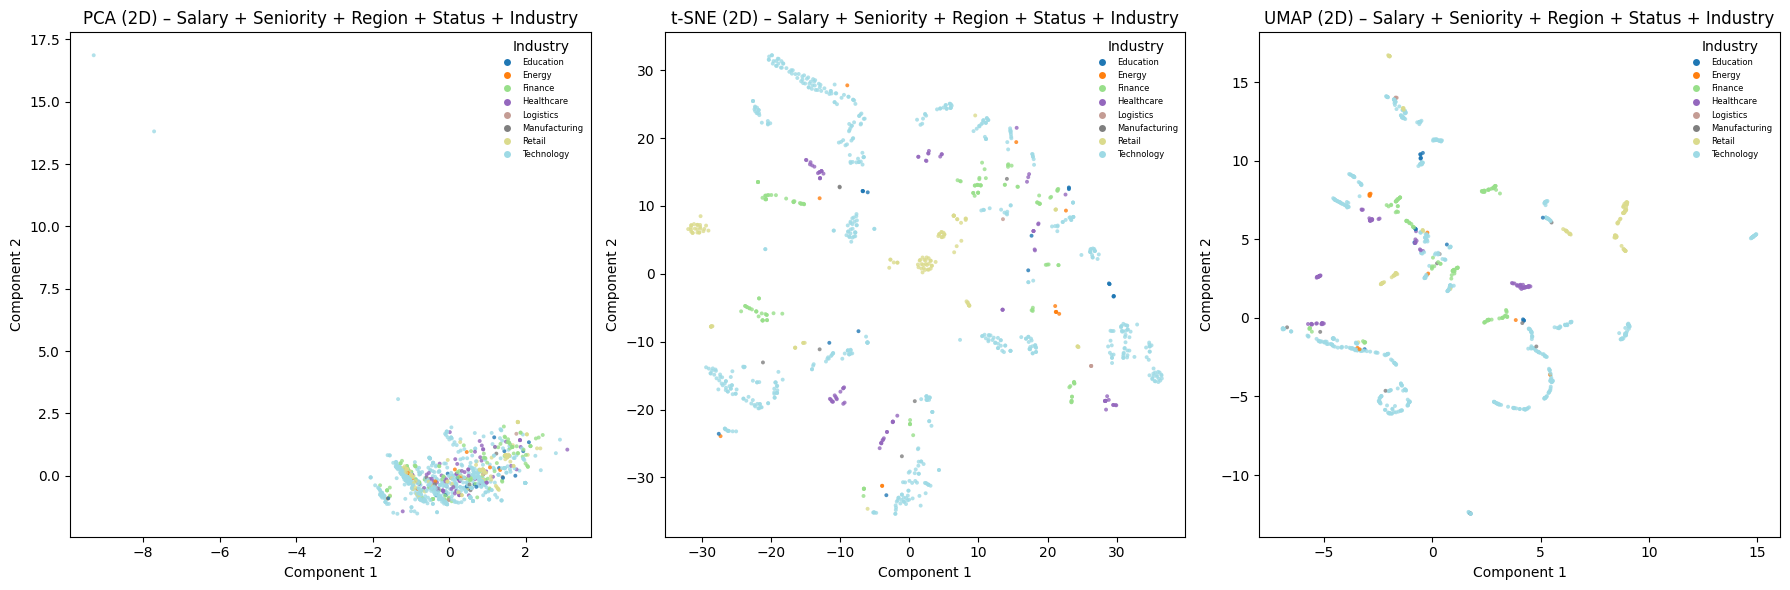

In [3]:
"""
Compute and plot PCA, t-SNE, and UMAP embeddings for job postings
using non-skill features:

- salary_mid (numeric)
- seniority_num (encoded from seniority_level_norm or seniority_level)
- fips_int (numeric state code)
- status (categorical, one-hot)
- industry (categorical, one-hot)

Color points by industry.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pip install umap-learn
import umap

# -------------------------------------------------------------------
# 1. Load data
# -------------------------------------------------------------------

CSV_PATH = "../data/data_science_job_posts_2025_clean.csv"  # <- change if needed

df = pd.read_csv(CSV_PATH)

# -------------------------------------------------------------------
# 2. Encode seniority into numeric
# -------------------------------------------------------------------

# We try to use `seniority_level_norm` if it exists,
# otherwise fall back to `seniority_level`.
seniority_source_col = None
if "seniority_level_norm" in df.columns:
    seniority_source_col = "seniority_level_norm"
elif "seniority_level" in df.columns:
    seniority_source_col = "seniority_level"

if seniority_source_col is not None:
    # If already numeric (rare), just copy it
    if pd.api.types.is_numeric_dtype(df[seniority_source_col]):
        df["seniority_num"] = df[seniority_source_col]
    else:
        # Convert categories to integer codes
        df["seniority_num"] = (
            df[seniority_source_col]
            .fillna("unknown")
            .astype("category")
            .cat.codes
        )
else:
    # If no seniority column at all, just set zeros
    df["seniority_num"] = 0

# -------------------------------------------------------------------
# 3. Check required columns
# -------------------------------------------------------------------

required_cols = [
    "salary_mid",
    "seniority_num",
    "fips_int",
    "status",
    "industry",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

# -------------------------------------------------------------------
# 4. Build feature matrix from numeric + categorical features
# -------------------------------------------------------------------

# 4.1 Numeric features
numeric_cols = ["salary_mid", "seniority_num", "fips_int"]

df_numeric = df[numeric_cols].copy()
df_numeric = df_numeric.apply(pd.to_numeric, errors="coerce")
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

scaler = StandardScaler()
X_numeric = scaler.fit_transform(df_numeric)

# 4.2 Categorical features: status + industry (one-hot)
df["status"] = df["status"].fillna("unknown_status")
df["industry"] = df["industry"].fillna("unknown_industry")

cat_cols = ["status", "industry"]
df_cat = pd.get_dummies(df[cat_cols], columns=cat_cols, drop_first=False)

# 4.3 Final feature matrix
X = np.hstack([X_numeric, df_cat.values])

print("Feature matrix shape (rows, dims):", X.shape)

# -------------------------------------------------------------------
# 5. Color encoding (by industry)
# -------------------------------------------------------------------

industry_series = df["industry"].fillna("unknown_industry")
unique_industries = sorted(industry_series.unique())
industry_to_idx = {ind: i for i, ind in enumerate(unique_industries)}
color_indices = industry_series.map(industry_to_idx).values

# Use a discrete colormap with enough colors
cmap = plt.cm.get_cmap("tab20", len(unique_industries))

# -------------------------------------------------------------------
# 6. Compute embeddings
# -------------------------------------------------------------------

# 6.1 PCA (2D)
pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(X)

# 6.2 t-SNE (2D)
tsne = TSNE(
    n_components=2,
    perplexity=30,         # you can tune (e.g., 30–50)
    learning_rate="auto",
    init="pca",
    random_state=42,
)
tsne_2d = tsne.fit_transform(X)

# 6.3 UMAP (2D)
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",    # good for scaled numeric + one-hot
    random_state=42,
)
umap_2d = umap_reducer.fit_transform(X)

# -------------------------------------------------------------------
# 7. Helper to plot an embedding
# -------------------------------------------------------------------

def plot_embedding(ax, embedding, title, color_indices, cmap, legend_labels):
    x = embedding[:, 0]
    y = embedding[:, 1]

    ax.scatter(
        x,
        y,
        c=color_indices,
        cmap=cmap,
        s=8,
        alpha=0.8,
        edgecolors="none",
    )
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    # Legend for industries (may be long if many industries)
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(
            plt.Line2D(
                [], [], marker="o", linestyle="", markersize=5,
                markerfacecolor=cmap(i), markeredgecolor="none", label=label
            )
        )

    # If there are too many industries, you can comment this out
    ax.legend(
        handles=handles,
        title="Industry",
        loc="best",
        fontsize=6,
        frameon=False,
    )

# -------------------------------------------------------------------
# 8. Plot all three embeddings side by side
# -------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_embedding(
    axes[0],
    pca_2d,
    "PCA (2D) – Salary + Seniority + Region + Status + Industry",
    color_indices,
    cmap,
    unique_industries,
)

plot_embedding(
    axes[1],
    tsne_2d,
    "t-SNE (2D) – Salary + Seniority + Region + Status + Industry",
    color_indices,
    cmap,
    unique_industries,
)

plot_embedding(
    axes[2],
    umap_2d,
    "UMAP (2D) – Salary + Seniority + Region + Status + Industry",
    color_indices,
    cmap,
    unique_industries,
)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 9. (Optional) Save embeddings for Vega-Lite / web plots
# -------------------------------------------------------------------

# embeddings_df = pd.DataFrame({
#     "id": df.index,
#     "pca_x": pca_2d[:, 0],
#     "pca_y": pca_2d[:, 1],
#     "tsne_x": tsne_2d[:, 0],
#     "tsne_y": tsne_2d[:, 1],
#     "umap_x": umap_2d[:, 0],
#     "umap_y": umap_2d[:, 1],
#     "industry": df["industry"],
#     "status": df["status"],
#     "salary_mid": df["salary_mid"],
#     "seniority_num": df["seniority_num"],
# })

# embeddings_df.to_csv("data/job_embeddings_macro_features_2d.csv", index=False)
# print("Saved embeddings to data/job_embeddings_macro_features_2d.csv")


Feature matrix shape (rows, dims): (941, 2)


/var/folders/0t/nvsb9hb16cz3yyv_k6byz7yr0000gn/T/ipykernel_47319/1235827227.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(unique_levels))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


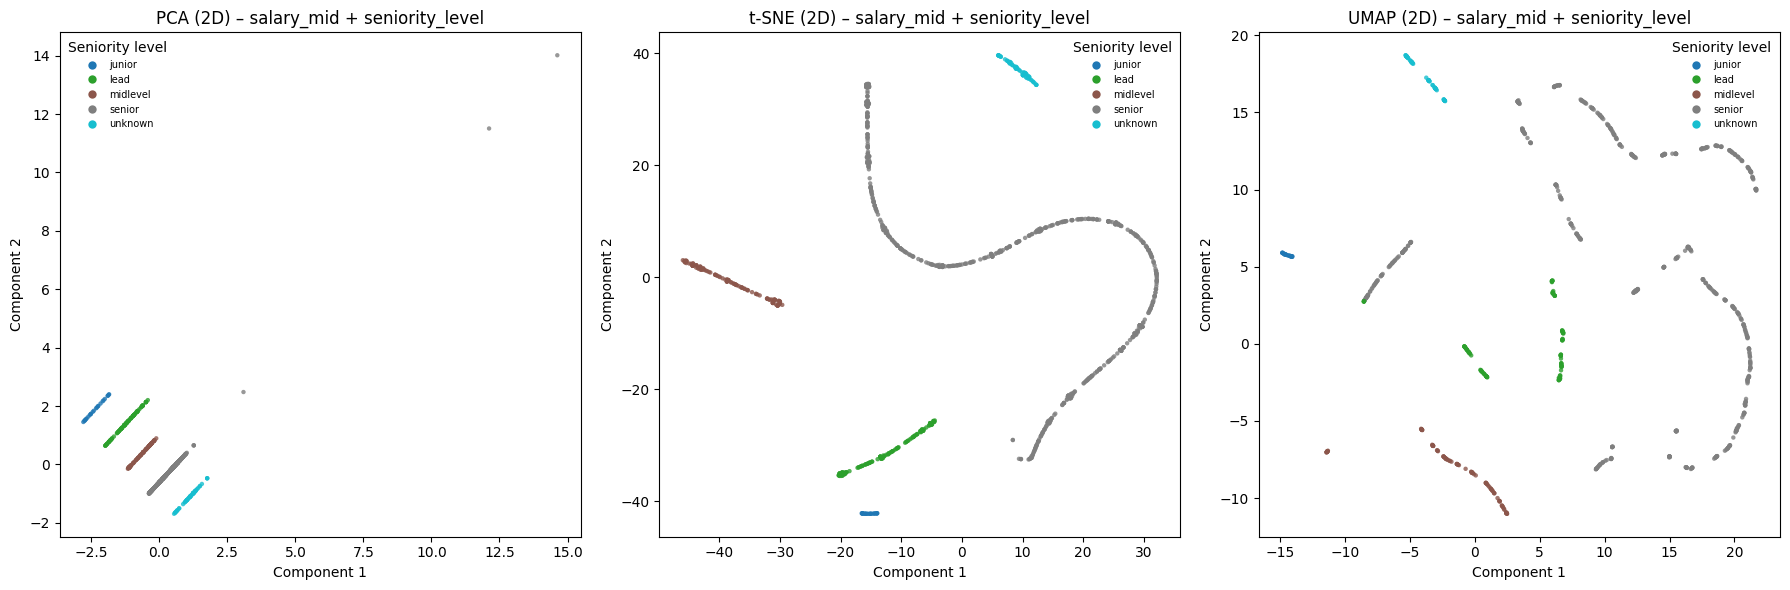

In [5]:
"""
Embeddings using ONLY:
- salary_mid
- seniority_level (encoded)

Then plot PCA, t-SNE, and UMAP in 2D.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pip install umap-learn
import umap

# ---------------------------------------------------------
# 1. Load data
# ---------------------------------------------------------

CSV_PATH = "../data/data_science_job_posts_2025_clean.csv"  # <- update if needed
df = pd.read_csv(CSV_PATH)

# ---------------------------------------------------------
# 2. Build numeric seniority + salary
# ---------------------------------------------------------

# Pick a seniority source column
# Prefer "seniority_level" if present, else "seniority_level_norm"
if "seniority_level" in df.columns:
    seniority_col = "seniority_level"
elif "seniority_level_norm" in df.columns:
    seniority_col = "seniority_level_norm"
else:
    raise ValueError("No seniority_level or seniority_level_norm column found.")

# Clean and encode seniority into integer codes
df[seniority_col] = df[seniority_col].fillna("unknown")
df["seniority_level_str"] = df[seniority_col].astype(str)  # keep for coloring

df["seniority_num"] = (
    df[seniority_col]
    .astype("category")
    .cat.codes
)

# Ensure salary exists
if "salary_mid" not in df.columns:
    raise ValueError("Expected column 'salary_mid' not found in dataframe.")

# ---------------------------------------------------------
# 3. Build feature matrix X (only 2 features)
# ---------------------------------------------------------

numeric_cols = ["salary_mid", "seniority_num"]

df_numeric = df[numeric_cols].copy()
df_numeric = df_numeric.apply(pd.to_numeric, errors="coerce")
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

scaler = StandardScaler()
X = scaler.fit_transform(df_numeric)

print("Feature matrix shape (rows, dims):", X.shape)

# ---------------------------------------------------------
# 4. Color encoding (by seniority level)
# ---------------------------------------------------------

levels = df["seniority_level_str"]
unique_levels = sorted(levels.unique())
level_to_idx = {lvl: i for i, lvl in enumerate(unique_levels)}
color_indices = levels.map(level_to_idx).values

cmap = plt.cm.get_cmap("tab10", len(unique_levels))

# ---------------------------------------------------------
# 5. Compute embeddings
# ---------------------------------------------------------

# 5.1 PCA (2D)
pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(X)

# 5.2 t-SNE (2D)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)
tsne_2d = tsne.fit_transform(X)

# 5.3 UMAP (2D)
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42,
)
umap_2d = umap_reducer.fit_transform(X)

# ---------------------------------------------------------
# 6. Helper to plot an embedding
# ---------------------------------------------------------

def plot_embedding(ax, embedding, title, color_indices, cmap, legend_labels):
    x = embedding[:, 0]
    y = embedding[:, 1]

    ax.scatter(
        x,
        y,
        c=color_indices,
        cmap=cmap,
        s=10,
        alpha=0.8,
        edgecolors="none",
    )
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    # Legend for seniority levels
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(
            plt.Line2D(
                [], [], marker="o", linestyle="", markersize=6,
                markerfacecolor=cmap(i), markeredgecolor="none", label=label
            )
        )

    ax.legend(
        handles=handles,
        title="Seniority level",
        loc="best",
        fontsize=7,
        frameon=False,
    )

# ---------------------------------------------------------
# 7. Plot all three embeddings side by side
# ---------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_embedding(
    axes[0],
    pca_2d,
    "PCA (2D) – salary_mid + seniority_level",
    color_indices,
    cmap,
    unique_levels,
)

plot_embedding(
    axes[1],
    tsne_2d,
    "t-SNE (2D) – salary_mid + seniority_level",
    color_indices,
    cmap,
    unique_levels,
)

plot_embedding(
    axes[2],
    umap_2d,
    "UMAP (2D) – salary_mid + seniority_level",
    color_indices,
    cmap,
    unique_levels,
)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 8. (Optional) Save embeddings for Vega-Lite
# ---------------------------------------------------------

# embeddings_df = pd.DataFrame({
#     "id": df.index,
#     "pca_x": pca_2d[:, 0],
#     "pca_y": pca_2d[:, 1],
#     "tsne_x": tsne_2d[:, 0],
#     "tsne_y": tsne_2d[:, 1],
#     "umap_x": umap_2d[:, 0],
#     "umap_y": umap_2d[:, 1],
#     "salary_mid": df["salary_mid"],
#     "seniority_level": df["seniority_level_str"],
#     "seniority_num": df["seniority_num"],
# })

# embeddings_df.to_csv("data/job_embeddings_salary_seniority_2d.csv", index=False)
# print("Saved embeddings to data/job_embeddings_salary_seniority_2d.csv")


Skill matrix shape: (941, 33)
Numeric matrix shape: (941, 2)
Categorical matrix shape: (941, 12)
Final feature matrix shape: (941, 47)


/var/folders/0t/nvsb9hb16cz3yyv_k6byz7yr0000gn/T/ipykernel_47319/1193216429.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_industries))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


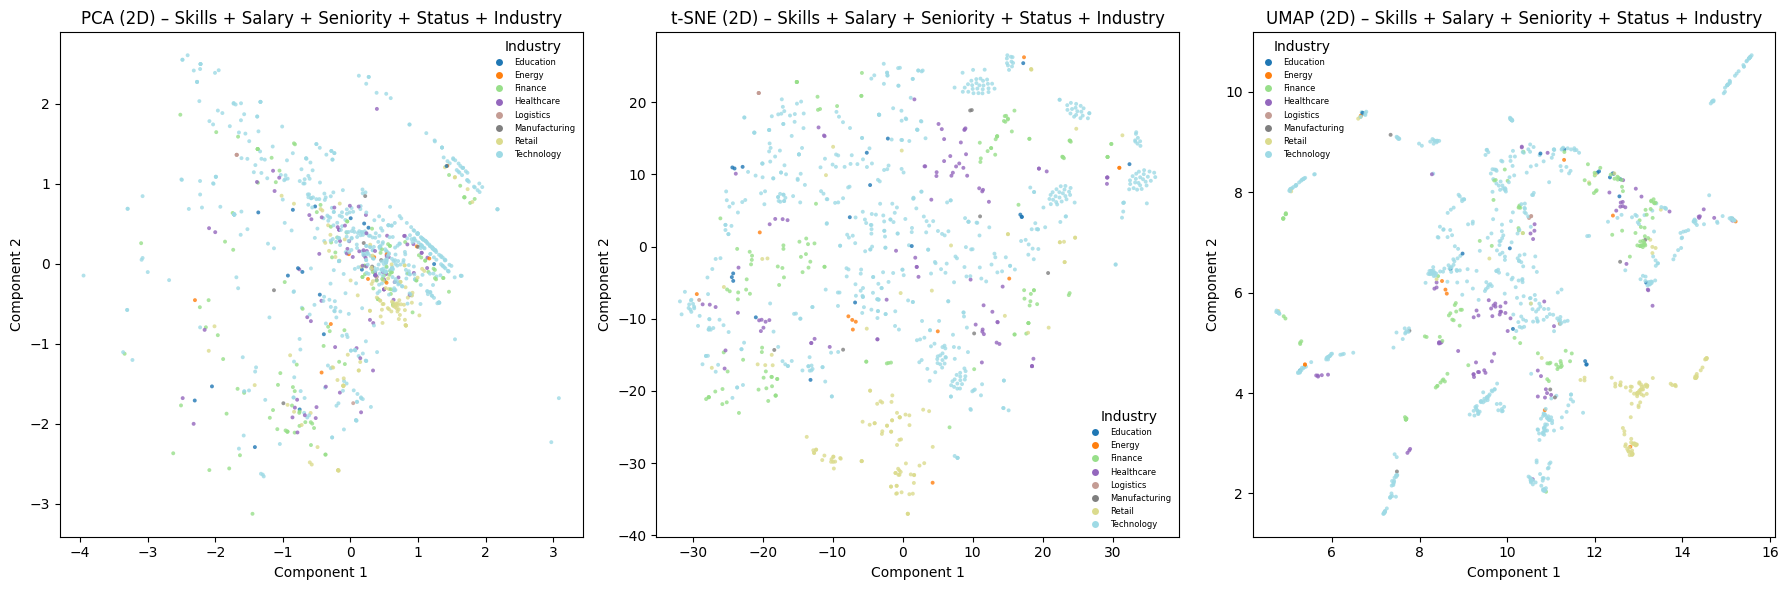

In [6]:
"""
Improved embeddings:

Features used:
- skills_list  -> multi-hot skill matrix
- salary_mid   -> log-scaled + standardized
- seniority_level (or seniority_level_norm) -> encoded to integer, standardized
- status       -> one-hot
- industry     -> one-hot

Outputs:
- PCA, t-SNE, UMAP 2D embeddings
- Colored by industry
"""

import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pip install umap-learn
import umap

# -------------------------------------------------------------------
# 1. Load data
# -------------------------------------------------------------------

CSV_PATH = "../data/data_science_job_posts_2025_clean.csv"  # update if needed
df = pd.read_csv(CSV_PATH)

# -------------------------------------------------------------------
# 2. Build skill features
# -------------------------------------------------------------------

if "skills_list" not in df.columns:
    raise ValueError("Expected column 'skills_list' not found in CSV.")

def parse_skills_list(s):
    if pd.isna(s):
        return []
    if isinstance(s, list):
        return s
    return ast.literal_eval(s)

df["skills_parsed"] = df["skills_list"].apply(parse_skills_list)

mlb = MultiLabelBinarizer()
X_skills = mlb.fit_transform(df["skills_parsed"])
print("Skill matrix shape:", X_skills.shape)

# -------------------------------------------------------------------
# 3. Numeric features: salary + seniority
# -------------------------------------------------------------------

# choose seniority source
if "seniority_level" in df.columns:
    seniority_col = "seniority_level"
elif "seniority_level_norm" in df.columns:
    seniority_col = "seniority_level_norm"
else:
    raise ValueError("No seniority_level or seniority_level_norm column found.")

df[seniority_col] = df[seniority_col].fillna("unknown")
df["seniority_str"] = df[seniority_col].astype(str)

# encode to integer codes
df["seniority_num"] = (
    df[seniority_col]
    .astype("category")
    .cat.codes
)

if "salary_mid" not in df.columns:
    raise ValueError("Expected column 'salary_mid' not found in CSV.")

# log-transform salary to reduce outlier influence
df["salary_mid"] = pd.to_numeric(df["salary_mid"], errors="coerce")
df["salary_log"] = np.log1p(df["salary_mid"])

numeric_cols = ["salary_log", "seniority_num"]
df_numeric = df[numeric_cols].copy()
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

scaler_num = StandardScaler()
X_numeric = scaler_num.fit_transform(df_numeric)
print("Numeric matrix shape:", X_numeric.shape)

# -------------------------------------------------------------------
# 4. Categorical features: status + industry (one-hot)
# -------------------------------------------------------------------

df["status"] = df.get("status", "unknown_status").fillna("unknown_status")
df["industry"] = df.get("industry", "unknown_industry").fillna("unknown_industry")

cat_cols = ["status", "industry"]
df_cat = pd.get_dummies(df[cat_cols], columns=cat_cols, drop_first=False)
X_cat = df_cat.values
print("Categorical matrix shape:", X_cat.shape)

# -------------------------------------------------------------------
# 5. Final feature matrix (skills + numeric + categorical)
# -------------------------------------------------------------------

X = np.hstack([X_skills, X_numeric, X_cat])
print("Final feature matrix shape:", X.shape)

# -------------------------------------------------------------------
# 6. Color encoding (by industry)
# -------------------------------------------------------------------

industry_series = df["industry"]
unique_industries = sorted(industry_series.unique())
industry_to_idx = {ind: i for i, ind in enumerate(unique_industries)}
color_indices = industry_series.map(industry_to_idx).values

cmap = plt.cm.get_cmap("tab20", len(unique_industries))

# -------------------------------------------------------------------
# 7. Compute embeddings
# -------------------------------------------------------------------

# 7.1 PCA
pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(X)

# 7.2 t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=35,         # slightly higher for more global structure
    learning_rate="auto",
    init="pca",
    random_state=42,
)
tsne_2d = tsne.fit_transform(X)

# 7.3 UMAP
umap_reducer = umap.UMAP(
    n_neighbors=25,        # a bit larger to stabilize clusters
    min_dist=0.05,         # smaller => tighter clusters
    metric="cosine",       # good for sparse/high-dim skill features
    random_state=42,
)
umap_2d = umap_reducer.fit_transform(X)

# -------------------------------------------------------------------
# 8. Helper to plot
# -------------------------------------------------------------------

def plot_embedding(ax, embedding, title, color_indices, cmap, legend_labels):
    x = embedding[:, 0]
    y = embedding[:, 1]

    ax.scatter(
        x,
        y,
        c=color_indices,
        cmap=cmap,
        s=8,
        alpha=0.8,
        edgecolors="none",
    )
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    # legend for industries
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(
            plt.Line2D(
                [], [], marker="o", linestyle="", markersize=5,
                markerfacecolor=cmap(i), markeredgecolor="none", label=label
            )
        )

    ax.legend(
        handles=handles,
        title="Industry",
        loc="best",
        fontsize=6,
        frameon=False,
    )

# -------------------------------------------------------------------
# 9. Plot all three side by side
# -------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_embedding(
    axes[0],
    pca_2d,
    "PCA (2D) – Skills + Salary + Seniority + Status + Industry",
    color_indices,
    cmap,
    unique_industries,
)

plot_embedding(
    axes[1],
    tsne_2d,
    "t-SNE (2D) – Skills + Salary + Seniority + Status + Industry",
    color_indices,
    cmap,
    unique_industries,
)

plot_embedding(
    axes[2],
    umap_2d,
    "UMAP (2D) – Skills + Salary + Seniority + Status + Industry",
    color_indices,
    cmap,
    unique_industries,
)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 10. (Optional) Save embeddings for Vega-Lite
# -------------------------------------------------------------------

# embeddings_df = pd.DataFrame({
#     "id": df.index,
#     "pca_x": pca_2d[:, 0],
#     "pca_y": pca_2d[:, 1],
#     "tsne_x": tsne_2d[:, 0],
#     "tsne_y": tsne_2d[:, 1],
#     "umap_x": umap_2d[:, 0],
#     "umap_y": umap_2d[:, 1],
#     "industry": df["industry"],
#     "status": df["status"],
#     "salary_mid": df["salary_mid"],
#     "salary_log": df["salary_log"],
#     "seniority_level": df["seniority_str"],
#     "seniority_num": df["seniority_num"],
# })

# embeddings_df.to_csv("data/job_embeddings_rich_features_2d.csv", index=False)
# print("Saved embeddings to data/job_embeddings_rich_features_2d.csv")


Feature matrix shape (rows, dims): (941, 3)


/var/folders/0t/nvsb9hb16cz3yyv_k6byz7yr0000gn/T/ipykernel_47319/3464576804.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(unique_levels))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


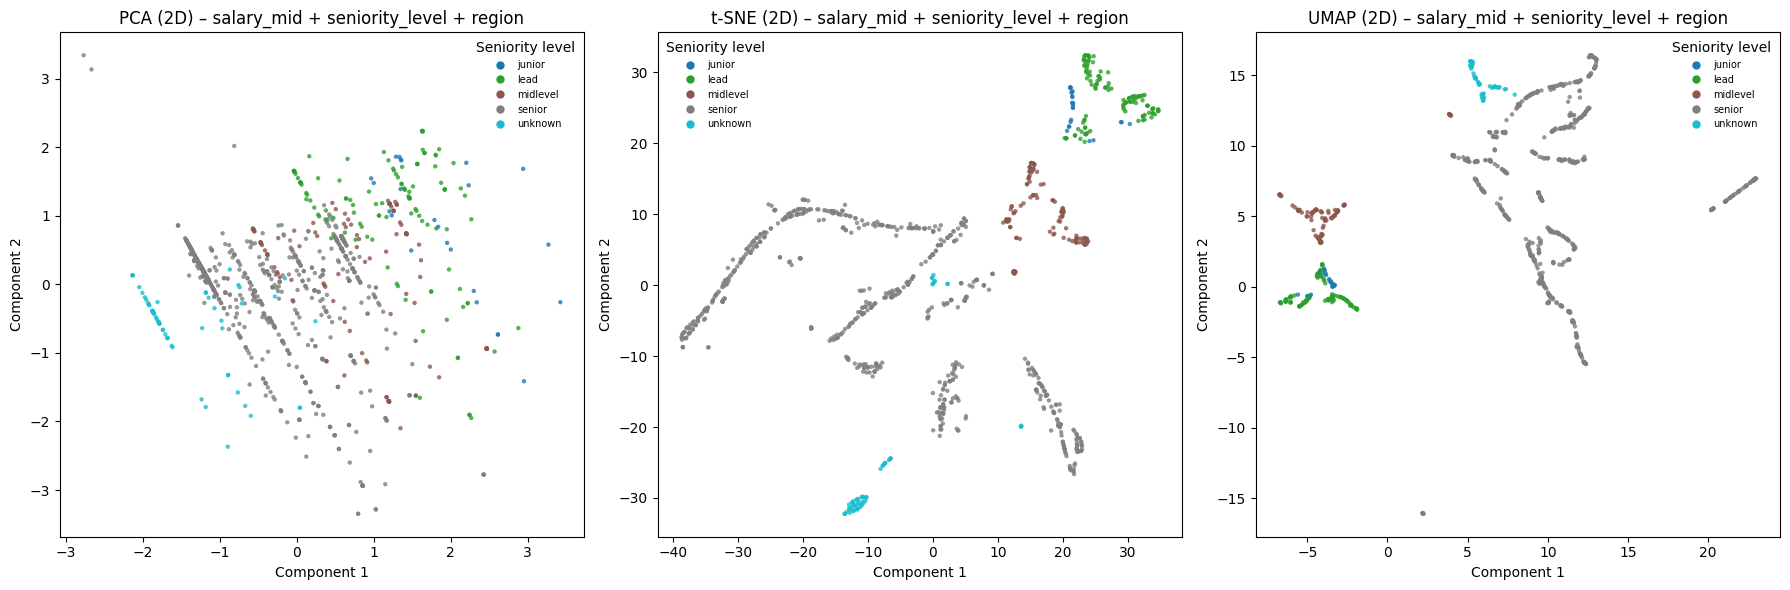

In [7]:
"""
Embeddings using:
- salary_mid  -> log-transformed
- seniority_level -> encoded to integer
- fips_int (state code)

Then plot PCA, t-SNE, and UMAP in 2D, colored by seniority level.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pip install umap-learn
import umap

# ---------------------------------------------------------
# 1. Load data
# ---------------------------------------------------------

CSV_PATH = "../data/data_science_job_posts_2025_clean.csv"  # <- update if needed
df = pd.read_csv(CSV_PATH)

# ---------------------------------------------------------
# 2. Seniority encoding
# ---------------------------------------------------------

# Prefer "seniority_level" if present, else "seniority_level_norm"
if "seniority_level" in df.columns:
    seniority_col = "seniority_level"
elif "seniority_level_norm" in df.columns:
    seniority_col = "seniority_level_norm"
else:
    raise ValueError("No seniority_level or seniority_level_norm column found.")

df[seniority_col] = df[seniority_col].fillna("unknown")
df["seniority_level_str"] = df[seniority_col].astype(str)  # keep for coloring

df["seniority_num"] = (
    df[seniority_col]
    .astype("category")
    .cat.codes
)

# ---------------------------------------------------------
# 3. Salary + region features
# ---------------------------------------------------------

if "salary_mid" not in df.columns:
    raise ValueError("Expected column 'salary_mid' not found.")
if "fips_int" not in df.columns:
    raise ValueError("Expected column 'fips_int' not found.")

# salary -> numeric + log1p
df["salary_mid"] = pd.to_numeric(df["salary_mid"], errors="coerce")
df["salary_log"] = np.log1p(df["salary_mid"])

# ensure fips_int is numeric
df["fips_int"] = pd.to_numeric(df["fips_int"], errors="coerce")

numeric_cols = ["salary_log", "seniority_num", "fips_int"]
df_numeric = df[numeric_cols].copy()
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

scaler = StandardScaler()
X = scaler.fit_transform(df_numeric)

print("Feature matrix shape (rows, dims):", X.shape)

# ---------------------------------------------------------
# 4. Color encoding (by seniority level)
# ---------------------------------------------------------

levels = df["seniority_level_str"]
unique_levels = sorted(levels.unique())
level_to_idx = {lvl: i for i, lvl in enumerate(unique_levels)}
color_indices = levels.map(level_to_idx).values

cmap = plt.cm.get_cmap("tab10", len(unique_levels))

# ---------------------------------------------------------
# 5. Compute embeddings
# ---------------------------------------------------------

# 5.1 PCA
pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(X)

# 5.2 t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=35,         # a bit higher to account for 3-D input
    learning_rate="auto",
    init="pca",
    random_state=42,
)
tsne_2d = tsne.fit_transform(X)

# 5.3 UMAP
umap_reducer = umap.UMAP(
    n_neighbors=20,
    min_dist=0.15,         # slightly larger for smoother, noisier blobs
    metric="euclidean",
    random_state=42,
)
umap_2d = umap_reducer.fit_transform(X)

# ---------------------------------------------------------
# 6. Helper to plot
# ---------------------------------------------------------

def plot_embedding(ax, embedding, title, color_indices, cmap, legend_labels):
    x = embedding[:, 0]
    y = embedding[:, 1]

    ax.scatter(
        x,
        y,
        c=color_indices,
        cmap=cmap,
        s=10,
        alpha=0.8,
        edgecolors="none",
    )
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    # Legend for seniority levels
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(
            plt.Line2D(
                [], [], marker="o", linestyle="", markersize=6,
                markerfacecolor=cmap(i), markeredgecolor="none", label=label
            )
        )

    ax.legend(
        handles=handles,
        title="Seniority level",
        loc="best",
        fontsize=7,
        frameon=False,
    )

# ---------------------------------------------------------
# 7. Plot all three embeddings side by side
# ---------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_embedding(
    axes[0],
    pca_2d,
    "PCA (2D) – salary_mid + seniority_level + region",
    color_indices,
    cmap,
    unique_levels,
)

plot_embedding(
    axes[1],
    tsne_2d,
    "t-SNE (2D) – salary_mid + seniority_level + region",
    color_indices,
    cmap,
    unique_levels,
)

plot_embedding(
    axes[2],
    umap_2d,
    "UMAP (2D) – salary_mid + seniority_level + region",
    color_indices,
    cmap,
    unique_levels,
)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 8. (Optional) Save embeddings for Vega-Lite
# ---------------------------------------------------------

# embeddings_df = pd.DataFrame({
#     "id": df.index,
#     "pca_x": pca_2d[:, 0],
#     "pca_y": pca_2d[:, 1],
#     "tsne_x": tsne_2d[:, 0],
#     "tsne_y": tsne_2d[:, 1],
#     "umap_x": umap_2d[:, 0],
#     "umap_y": umap_2d[:, 1],
#     "salary_mid": df["salary_mid"],
#     "salary_log": df["salary_log"],
#     "seniority_level": df["seniority_level_str"],
#     "seniority_num": df["seniority_num"],
#     "fips_int": df["fips_int"],
# })

# embeddings_df.to_csv("data/job_embeddings_salary_seniority_region_2d.csv", index=False)
# print("Saved embeddings to data/job_embeddings_salary_seniority_region_2d.csv")
